# 0. Set up
## 0.1 If if needed, clone Demeter with git

In [1]:
!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

and install the package

In [2]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/


print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)
!pip install pynrrd
!pip install --upgrade ipywidgets

In [ ]:
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension

## 0.2 After jupyter restart, run :

In [3]:


import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

# 1. code utile

## imports

In [1]:
import demeter.utils.torchbox as tb
from demeter.constants import *
import demeter.metamorphosis as mt
import demeter.utils.reproducing_kernels as rk
import demeter.utils.rigid_exploration as rg

import sys
import os

# Add the directory containing brats_utils to the Python path
brats_utils_path = os.path.join(os.path.abspath('.'), 'examples/') # Assuming brats_utils is in a 'src' subdirectory
print(brats_utils_path)

if brats_utils_path not in sys.path:
    sys.path.insert(0, brats_utils_path)

import brats_utils as bu

%load_ext autoreload
%autoreload 2
import demeter.metamorphosis.rotate as mtrt
import demeter.utils.axes3dsliders_plt as a3s
from scipy.spatial.transform import Rotation as R


# term_width = os.get_terminal_size().columns
term_width = 30


def prepare_momenta(image_shape,
                    image : bool = True,
                    rotation : bool = True,
                    translation : bool = True,
                    rot_prior = None,
                    trans_prior= None,
                    device = "cuda:0",
                    requires_grad = True):
    dim = 2 if len(image_shape) == 4 else 3
    if rot_prior is None:
        rot_prior = torch.zeros((dim,))
    if trans_prior is None:
        trans_prior = [0] * dim
    momenta = {}
    kwargs = {
        "dtype":torch.float32,
        "device":device
    }
    if image:
        momenta["momentum_I"]= torch.zeros(S.shape,**kwargs)
    if rotation:
        if len(rot_prior.shape)==2:
            momenta["momentum_R"] = torch.tensor(rot_prior,**kwargs)
        elif len(rot_prior.shape)==1:
            r1, r2, r3 = rot_prior
            momenta["momentum_R"] = torch.tensor(
            [[0,-r1, -r2 ],
                     [r1, 0, -r3],
                     [r2, r3, 0]],
                    dtype=torch.float32, device='cuda:0')
        else:
            raise ValueError("Rotation prior must be 2 or 1 dimensional")
    if translation:
        momenta["momentum_T"]= torch.tensor(trans_prior,
                                            **kwargs)

    for keys in momenta.keys():
        momenta[keys].requires_grad=requires_grad

    return momenta

def random_affine_def():
    rdm_angle = torch.randn((3,))/4
    rdm_translation = torch.randn((3,))/15

    args_aff = torch.cat(
        [
            rdm_angle,
            rdm_translation,
            torch.ones_like(rdm_angle)
        ], dim = 0
    )
    print(args_aff)

    # args_aff = torch.tensor(
    #         [.6,-.3, 0, # angle
    #         .1,.02,0,   # translation
    #         1,1,1] # scaling
    # )
    aff_mat = tb.create_affine_mat_3d(args_aff)
    print(aff_mat)
    aff_grid = tb.affine_to_grid_3d(aff_mat, img_1.shape[2:])
    return aff_grid, aff_mat


def pixel_to_2square_landmark(landmarks, image_size):
    if len(image_size) > 3:
        image_size = image_size[2:]
    landmarks = landmarks.clone().float()
    for i in range(landmarks.shape[1]):
        landmarks[:,i] *= 2/ (image_size[i] )
    return landmarks - 1

def test_pixel_to_2square_landmark():
    landmarks = torch.tensor(
        [[0,0,0],[240,240,155],[240//2, 240//2, 155//2]]
    )
    img_shape = (1, 1, 240, 240, 155)
    expected_result = torch.tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000, -0.0065]])
    actual_result = pixel_to_2square_landmark(landmarks, img_shape)
    print('landmarks',landmarks)
    print("landmarks processed",pixel_to_2square_landmark(landmarks,img_shape))
    assert expected_result == actual_result

def apply_aff_to_landmarks(landmarks, grid):
    """
    Transport landmarks by a deformation grid.
    """
    new_land = torch.zeros_like(landmarks)
    for i, l in enumerate(landmarks):
        new_land[i]  = grid[:, int(l[2]), int(l[1]), int(l[0])]            # Bad orient

    return new_land

def inverse_affine(affine):
    """
    Compute the inverse of the affine transformation.
    """
    rot = affine[:3, :3]
    trans = affine[:3, 3][None]
    inv_rot = rot.T
    inv_trans = - trans.T

    new_aff = torch.cat([inv_rot, inv_trans], dim=1)
    return  torch.cat([new_aff, affine[-1][None]], dim=0)

saves_overview.csv
/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/examples/examples/
🔍 Vérification de l'environnement Matplotlib interactif...
✅ ipympl est installé.
✅ `%matplotlib widget` activé avec succès.
✅ Backend interactif actif : widget
🎉 Environnement prêt pour les mises à jour dynamiques avec `.set_data()` et sliders interactifs !


# Open raw images

torch.Size([6, 3])
torch.Size([1, 1, 240, 240, 155])
torch.Size([1, 1, 240, 240, 155])
landmarks 0 
 tensor([[ 56.,  88.,  70.],
        [ 68., 146., 120.],
        [ 79., 151., 120.],
        [ 73., 121.,  57.],
        [ 52.,  90., 119.],
        [ 46., 106., 107.]])
landmarks 1 
 tensor([[ 59.,  88.,  69.],
        [ 68., 146., 122.],
        [ 76., 154., 120.],
        [ 74., 120.,  57.],
        [ 52.,  90., 120.],
        [ 49., 106., 107.]])


ic| axes3dsliders_plt.py:636 in _add_lines_on_plt_()- 120, 120, 77


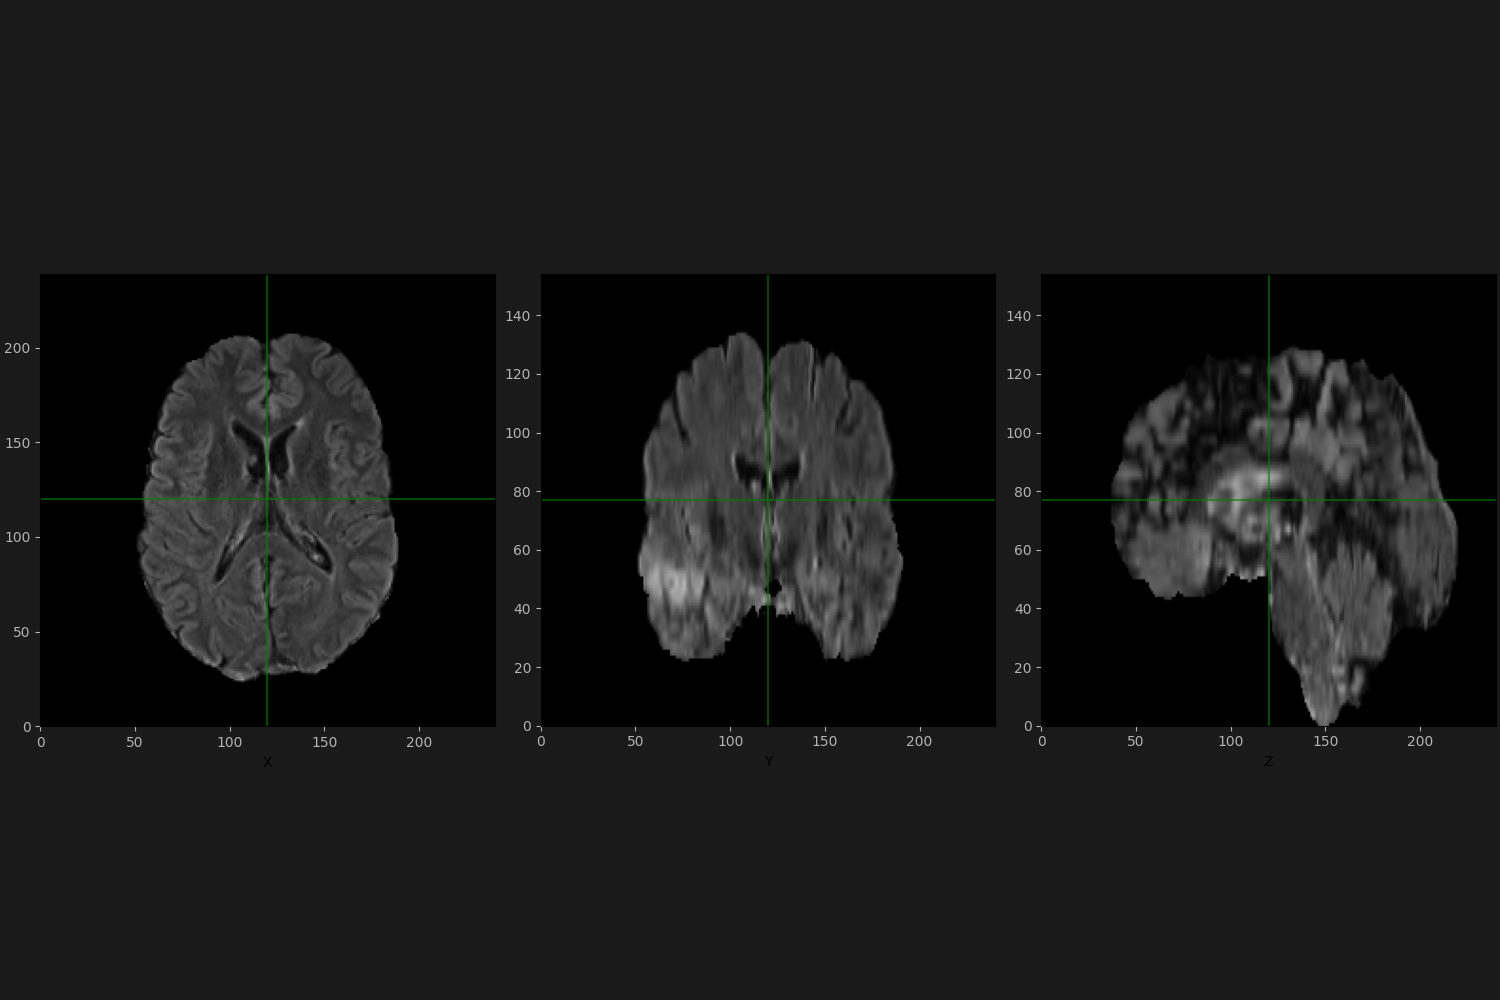

In [7]:
brats_list = [
        # "BraTSReg_086",
        #"BraTSReg_090","BraTSReg_084",
        # "BraTSReg_046",
        # "BraTSReg_002",
    "BraTSReg_021",
    #     "BraTSReg_040",
    # "BraTSReg_118","BraTSReg_114","BraTSReg_132",

        # "BraTSReg_101","BraTSReg_073","BraTSReg_025","BraTSReg_022","BraTSReg_068","BraTSReg_120","BraTSReg_031","BraTSReg_088","BraTSReg_006","BraTSReg_003","BraTSReg_024","BraTSReg_035","BraTSReg_076","BraTSReg_012","BraTSReg_123",
    # 'BraTSReg_034',
    #     'BraTSReg_048',
    # 'BraTSReg_055', 'BraTSReg_082', 'BraTSReg_045', 'BraTSReg_089', 'BraTSReg_057',
        # 'BraTSReg_096', 'BraTSReg_083', 'BraTSReg_042', 'BraTSReg_061', 'BraTSReg_074', 'BraTSReg_097', 'BraTSReg_056', 'BraTSReg_033', 'BraTSReg_136', 'BraTSReg_119', 'BraTSReg_108', 'BraTSReg_054', 'BraTSReg_091', 'BraTSReg_100', 'BraTSReg_030', 'BraTSReg_126', 'BraTSReg_133', 'BraTSReg_138', 'BraTSReg_053', 'BraTSReg_110', 'BraTSReg_079',
    # 'BraTSReg_008', 'BraTSReg_131', 'BraTSReg_001', 'BraTSReg_023', 'BraTSReg_064', 'BraTSReg_067', 'BraTSReg_115', 'BraTSReg_029', 'BraTSReg_093', 'BraTSReg_129', 'BraTSReg_005',
    #  'BraTSReg_140',
        #'BraTSReg_036', 'BraTSReg_071'
    ]


device = 'cuda:0'
valid = False
brats_folder= '2022_valid' if valid else '2022_train'
modality = 'flair'
pb = bu.parse_brats(brats_list=brats_list,brats_folder=brats_folder,modality=modality)
save_folder = None
scale_img = 1

i = 0
img_1,img_2,seg_1,seg_2,landmarks = pb(i,to_torch=True,scale=scale_img,modality=modality)

# img_1 = torch.nn.functional.pad(img_1,(0,0,10,20,0,0), "constant",.5)
print(landmarks[0].shape)
print(img_1.shape)
print(img_2.shape)
# land_2square =  pixel_to_2square_landmark(landmarks[0], img_1.shape)
# ic(landmarks,land_2square)
land_1, land_2 = landmarks
# land_1 =  land_0 +5
print("landmarks 0 \n",land_1)
print("landmarks 1 \n", land_2)
id_grid = tb.make_regular_grid( img_1.shape[2:])

ias = a3s.Image3dAxes_slider(img_1)
plt.show()

tensor([ 0.3852, -0.0734, -0.5447,  0.0379, -0.0723, -0.0932,  1.0000,  1.0000,
         1.0000])
tensor([[ 0.9242, -0.2862, -0.2528,  0.0379],
        [ 0.3748,  0.8069,  0.4566, -0.0723],
        [ 0.0733, -0.5168,  0.8530, -0.0932],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/utils/axes3dsliders_plt.py:1303: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic("image_0", image0.shape)
ic| axes3dsliders_plt.py:1303 in compare_images_with_landmarks()
    'image_0'
    torch.Size([1, 1, 240, 240, 155])


land_0_aff tensor([[ 44.7290, 137.6316,  82.2751],
        [ 72.1872, 153.2613, 146.7003],
        [ 83.5610, 152.4096, 144.6676],
        [ 67.7958, 163.4249,  79.5850],
        [ 43.8292, 115.7006, 126.5539],
        [ 41.5810, 137.4767, 125.9782]])


ic| axes3dsliders_plt.py:636 in _add_lines_on_plt_()- 120, 120, 77


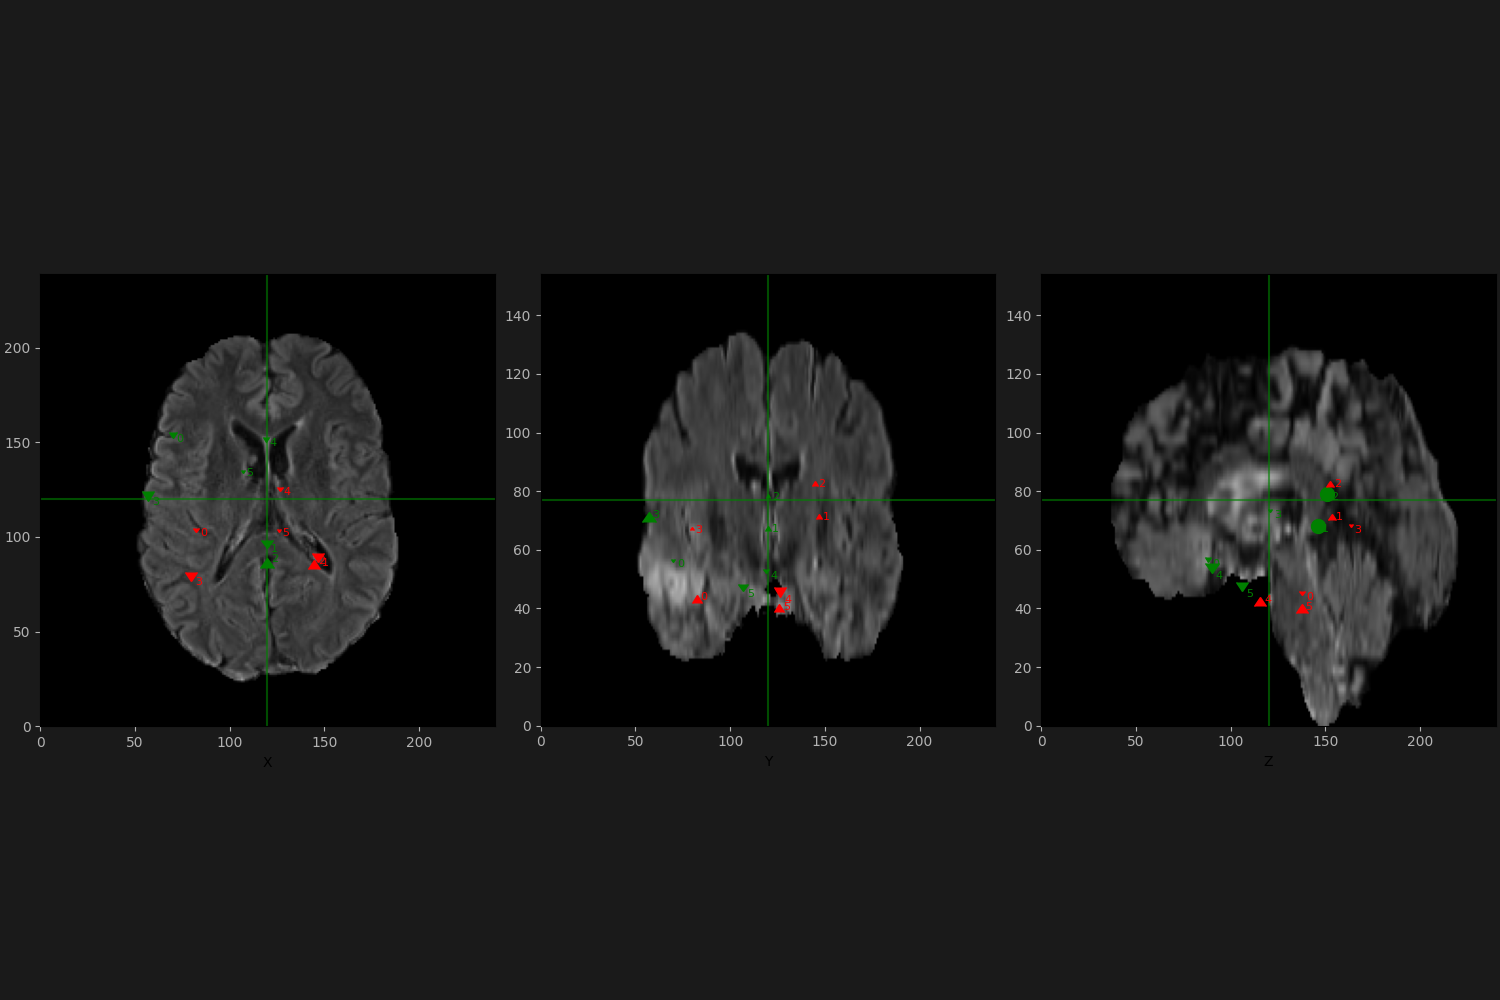

Images ready to be registred
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [8]:
torch.manual_seed(0)
grid, affine = random_affine_def()

# param = torch.tensor([
#     0,0,torch.pi/3,
#     0,0,0,
#     1,1,1
# ])
# affine = tb.create_affine_mat_3d(param)
# grid = tb.affine_to_grid_3d(affine, img_1.shape[2:])
inv_aff = inverse_affine(affine)
inv_grid = tb.affine_to_grid_3d(inv_aff, img_1.shape[2:])

img_1_aff = tb.imgDeform(img_1, grid  )

inv_grid = tb.square2_to_pixel_convention(inv_grid,True)
land_1_aff = apply_aff_to_landmarks(land_1, inv_grid)



print("land_0_aff", land_1_aff)
a3s.compare_images_with_landmarks(img_1, img_1_aff, land_1, land_1_aff, labels = ["origin", "displaced"])

print("Images ready to be registred")
print("^"*term_width)

source =  img_1_aff.contiguous()
target  = img_2.contiguous()

# Apply Metamorphosis
## barycentre alignement

In [9]:
print("="*term_width)
print("Barycentre alignement\n")
shape_list = torch.tensor(source.size()[2:])/2
print(source.shape)
print(shape_list)

source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
land_1_b = land_1 - trans_s * shape_list
land_2_b = land_2 - trans_t * shape_list
print(land_1, land_1_b)
print(land_2, land_2_b)
# a3s.compare_images_with_landmarks(source, source_b,
#                                   land_1, land_1_b,
#                                   labels = ["source", "source_barycentred"])
# a3s.compare_images_with_landmarks(target, target_b,land_2, land_2_b,
#                                   labels = ["target", "target_barcentred"])
# a3s.compare_images_with_landmarks(source_b, target_b,
#                                   land_1_b, land_2_b,
#                                   labels = ["source_barycentred", 'target_barcentred'])

Barycentre alignement

torch.Size([1, 1, 240, 240, 155])
tensor([120.0000, 120.0000,  77.5000])
S compute barycentre : tensor([-0.0496,  0.1425,  0.1899])
T compute barycentre : tensor([-0.0790,  0.1302, -0.0551])
diff :  tensor([-0.0294, -0.0123, -0.2450])
tensor([[ 56.,  88.,  70.],
        [ 68., 146., 120.],
        [ 79., 151., 120.],
        [ 73., 121.,  57.],
        [ 52.,  90., 119.],
        [ 46., 106., 107.]]) tensor([[ 61.9491,  70.9023,  55.2849],
        [ 73.9491, 128.9023, 105.2849],
        [ 84.9491, 133.9023, 105.2849],
        [ 78.9491, 103.9023,  42.2849],
        [ 57.9491,  72.9023, 104.2849],
        [ 51.9491,  88.9023,  92.2849]])
tensor([[ 59.,  88.,  69.],
        [ 68., 146., 122.],
        [ 76., 154., 120.],
        [ 74., 120.,  57.],
        [ 52.,  90., 120.],
        [ 49., 106., 107.]]) tensor([[ 68.4796,  72.3746,  73.2688],
        [ 77.4796, 130.3746, 126.2688],
        [ 85.4796, 138.3746, 124.2688],
        [ 83.4796, 104.3746,  61.2688],
   

## Prepare Metamorphosis optimizer

In [10]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=1)


mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)

dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])


## Rigid Explorator

In [11]:

top_params = rg.initial_exploration(mr,r_step=3, max_output = 5, verbose=True)
print(top_params)

# top_params =  [
#     (torch.tensor(22700.7285), torch.tensor([-3.1416, -0.6283,  1.8850])),
#     (torch.tensor(22830.1152), torch.tensor([ 0.6283, -3.1416,  1.8850])),
# ]

Init search : 1 / 27
dict_keys(['momentum_R'])
	 (tensor(27990.1035), tensor([-3.1416, -3.1416, -3.1416]))
Init search : 2 / 27
dict_keys(['momentum_R'])
	 (tensor(27528.5156), tensor([-3.1416, -3.1416, -1.0472]))
Init search : 3 / 27
dict_keys(['momentum_R'])
	 (tensor(28032.3320), tensor([-3.1416, -3.1416,  1.0472]))
Init search : 4 / 27
dict_keys(['momentum_R'])
	 (tensor(26797.5703), tensor([-3.1416, -1.0472, -3.1416]))
Init search : 5 / 27
dict_keys(['momentum_R'])
	 (tensor(24228.0078), tensor([-3.1416, -1.0472, -1.0472]))
Init search : 6 / 27
dict_keys(['momentum_R'])
	 (tensor(27334.2793), tensor([-3.1416, -1.0472,  1.0472]))
Init search : 7 / 27
dict_keys(['momentum_R'])
	 (tensor(28568.1914), tensor([-3.1416,  1.0472, -3.1416]))
Init search : 8 / 27
dict_keys(['momentum_R'])
	 (tensor(27942.3086), tensor([-3.1416,  1.0472, -1.0472]))
Init search : 9 / 27
dict_keys(['momentum_R'])
	 (tensor(30181.9336), tensor([-3.1416,  1.0472,  1.0472]))
Init search : 10 / 27
dict_keys(['mom

## Optimize Rigid on best values


In [12]:
best_loss, best_momentum, best_translation, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)
rot_def =   tb.apply_rot_mat(mr.mp.id_grid, best_rot.T)
# rot_def -= best_translation
# img_rot = tb.imgDeform(mr.mp.image, rot_def.to('cpu'),
#                        dx_convention='2square', clamp=True)
# 
# a3s.compare_images_with_landmarks(img_rot, source_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "source_b"],)
# 
# a3s.compare_images_with_landmarks(img_rot, target_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "target_b"],)

# best_momentum = torch.tensor([[ 0.0000,  1.9314,  0.9529],
#         [-1.9314,  0.0000, -2.8442],
#         [-0.9529,  2.8442,  0.0000]])
# best_translation = torch.tensor([ 0.0488, -0.1214, -0.0680])

>>>>>>>>>>
0/5 Optimize wit params [-3.1415927410125732, -1.0471975803375244, -1.0471975803375244]
momenta type <class 'dict'>
momenta keys dict_keys(['momentum_R', 'momentum_T'])
Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,23891.3496).
Progress: [###-------]  30.00%  (Rotation_Ssd_Cost : ,23847.3984).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,23757.6133).
Progress: [#####-----]  50.00%  (Rotation_Ssd_Cost : ,23757.0938).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,23757.0938).
Progress: [#######---]  70.00%  (Rotation_Ssd_Cost : ,23757.0938).
Progress: [########--]  80.00%  (Rotation_Ssd_Cost : ,23757.0938).
Progress: [#########-]  90.00%  (Rotation_Ssd_Cost : ,23757.0938).
Progress: [##########] 100.00% Done...
 (Rotation_Ssd_Cost : ,23757.0938).

Computation of forward done in  0:00:10s and 0.272cents  s
best = True
tensor([0.0967, 0.0548, 0.0378])
tensor([[ 0.0684,  0.8888,  0.4531],
        [-0.9969,  0.0429,  0.0665],
        [ 0.0397, -0.4562,  0.

## Metamorphosis along rigid

In [13]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)


momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=True,
    rotation=True,
    translation=True,
    # rot_prior=best_momentum.detach().clone(),trans_prior=best_translation.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)

mr = mt.rigid_along_metamorphosis(
    img_1, img_2, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=10,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)

# mr = mt.metamorphosis(
#     img_1, img_2, momentum_ini=momenta,
#     kernelOperator= kernelOperator,
#     rho = 1,
#     data_term=datacost ,
#     integration_steps = 10,
#     cost_cst=.1,
#     n_iter=10,
#     grad_coef=1
# )

mr.plot_cost()

a3s.compare_images_with_landmarks(mr.mp.image, img_1,
                                  labels= ["Final", "source"],)
a3s.compare_images_with_landmarks(mr.mp.image, img_2,
                                  labels= ["Final", "target_b"],)

True
True
True
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
momenta type <class 'dict'>
momenta keys dict_keys(['momentum_I', 'momentum_R', 'momentum_T'])


OutOfMemoryError: CUDA out of memory. Tried to allocate 308.00 MiB. GPU 0 has a total capacity of 7.65 GiB of which 149.19 MiB is free. Including non-PyTorch memory, this process has 7.49 GiB memory in use. Of the allocated memory 6.68 GiB is allocated by PyTorch, and 689.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)